In [14]:
import pandas as pd 
from conexion import open_conexion_get,desencriptar_archivo
from fechas import *
from datetime import timedelta
import ta
import matplotlib.pyplot as plt
from tabulate import tabulate
# Prueba de hipotesis
from scipy import stats
import numpy as np

In [ ]:
# Lee la clave hash para desencriptar
with open('Data/clave.key', 'r') as clave_file:
    clave = clave_file.read()
# Lee las contraseñas del archivo encriptado y muestra el resultado deseado
contraseñas = desencriptar_archivo('Data/credenciales.txt', clave)

In [16]:
con = open_conexion_get('HectorLP5',contraseñas['MYSQL_PASSW'],database='BNB')

In [9]:
intervalos = ["1d","12h","8h","6h","4h","2h","1h"]
simbolos = ['BTCUSDT','TRXUSDT',"BNBUSDT","XRPUSDT","ETHUSDT"]
# BNB: ['BNBBTC', 'BNBETH', 'BNBUSDT', 'BNBTUSD', 'BNBUSDC', 'BNBBUSD',
#       'BNBRUB', 'BNBTRY', 'BNBEUR', 'BNBGBP', 'BNBBIDR', 'BNBDAI',
#       'BNBBRL', 'BNBUAH', 'BNBFDUSD']

In [17]:
interval = "4h"
symbol = "BNBBTC"
table_name = symbol +'_'+ interval
#con = sqlite3.connect('Data/'+symbol)

df = pd.read_sql_query(f"""
                      SELECT *
                      FROM {table_name}
                      """, con)

df.Name = table_name
df.Close_Time = df.Close_Time #+ timedelta(seconds=1)
# Hacer index la fecha
df = df.set_index("Close_Time")
# Hacer respaldo 
df_respaldo = df.copy()
df.shape

(8146, 10)

In [18]:
df = df_respaldo.copy()

# Analizar del 2022 al ultimo
df = df[df.index > '2020-01-01']
df.tail()


,Open_Time,Open,High,Low,Close,Volumne,Quote_asset_vol,Number_trades,Taker_buy_base,Taker_buy_quote
Close_Time,,,,,,,,,,
2023-09-19 06:00:00,2023-09-19 02:00:00,0.008081,0.008088,0.008006,0.008015,5940.188,47.781540,6328,2149.978,17.284651
2023-09-19 10:00:00,2023-09-19 06:00:00,0.008014,0.008050,0.007941,0.007961,6426.224,51.413092,7952,2934.947,23.475277
2023-09-19 14:00:00,2023-09-19 10:00:00,0.007960,0.008006,0.007952,0.007979,3182.359,25.407362,4627,1568.056,12.515532
2023-09-19 18:00:00,2023-09-19 14:00:00,0.007980,0.008007,0.007974,0.007981,2356.972,18.826701,3219,1122.303,8.964212
2023-09-19 22:00:00,2023-09-19 18:00:00,0.007981,0.007981,0.007968,0.007972,185.066,1.475613,349,80.435,0.641219


In [ ]:
df_respaldo.tail(4)

In [26]:
con.close()

## Media  movil 

In [ ]:
# Version manual
col = 'Close'
moving_average = df[col].rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)


ax = df[col].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

In [45]:
# Version libreria ta.
col_use = "Close"
df['EMA7'] = ta.trend.EMAIndicator(close=   df[col_use], window= 7, fillna= False).ema_indicator()
df['EMA14'] = ta.trend.EMAIndicator(close=  df[col_use], window= 14, fillna= False).ema_indicator()
df['EMA50'] = ta.trend.EMAIndicator(close=  df[col_use], window= 50, fillna= False).ema_indicator()
df['EMA200'] = ta.trend.EMAIndicator(close= df[col_use], window= 200,fillna= False).ema_indicator()

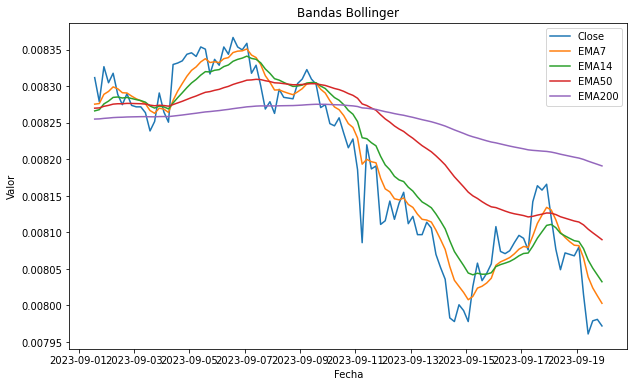

In [49]:
# Graficar EMA's
start_date = '2023-09-01 10:00:00'

df_plot = df[df.index>start_date].copy()
plt.figure(figsize=(10, 6))
plt.plot(df_plot.index, df_plot[col_use], label='Close')
plt.plot(df_plot.index, df_plot['EMA7'], label='EMA7')
plt.plot(df_plot.index, df_plot['EMA14'], label='EMA14')
plt.plot(df_plot.index, df_plot['EMA50'], label='EMA50')
plt.plot(df_plot.index, df_plot['EMA200'], label='EMA200')
plt.legend()
plt.title('Bandas Bollinger')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.show()

## Bandas bollinguer

In [ ]:
# Version manual
import matplotlib.pyplot as plt

def calcular_bandas_bollinger(datos, ventana, desviacion):
    datos['Media'] = datos['Close'].rolling(window=ventana).mean()
    datos['Desviacion'] = datos['Close'].rolling(window=ventana).std()
    datos['BandaSuperior'] = datos['Media'] + (datos['Desviacion'] * desviacion)
    datos['BandaInferior'] = datos['Media'] - (datos['Desviacion'] * desviacion)
    return datos

def analizar_bandas(datos,col_use='Close'):
    señales = []
    for i in range(len(datos)):
        if datos[col_use][i] > datos['BandaSuperior'][i]:
            señales.append('Venta')
        elif datos[col_use][i] < datos['BandaInferior'][i]:
            señales.append('Compra')
        else:
            señales.append('Esperar')
    return señales


# Parámetros de las Bandas Bollinger
ventana = 3
desviacion = 2
col_use = 'Close'

# Calcular las Bandas Bollinger
df = calcular_bandas_bollinger(df, ventana, desviacion)

# Analizar señales de compra/venta
df['Señal'] = analizar_bandas(df)

# Imprimir el DataFrame con las Bandas Bollinger y las señales
#print(df)

# Graficar las Bandas Bollinger
plt.figure(figsize=(10, 6))
plt.plot(df.index, df[col_use], label='Close')
plt.plot(df.index, df['BandaSuperior'], label='Banda Superior')
plt.plot(df.index, df['BandaInferior'], label='Banda Inferior')
plt.legend()
plt.title('Bandas Bollinger')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.show()

In [31]:
# Version libreria ta.
col_use = 'Close'
ventana = 20
desviacion = 2

# Indicador bb: It returns 1, if col_use is higher than bollinger_hband. Else, it returns 0.
df['BBH_indicator']=ta.volatility.BollingerBands(df[col_use], 
                                                 window = ventana,
                                                 window_dev = desviacion,
                                                 fillna = False).bollinger_hband_indicator()
# Indicador bb: It returns 1, if col_use is lower than bollinger_lband. Else, it returns 0.
df['BBL_indicator']=ta.volatility.BollingerBands(df[col_use],
                                                 window = ventana,
                                                 window_dev = desviacion,
                                                 fillna = False).bollinger_lband_indicator()

In [38]:
# Valor bb higher
df['BBH']=ta.volatility.BollingerBands(df[col_use], 
                                                 window = ventana,
                                                 window_dev = desviacion,
                                                 fillna = False).bollinger_hband()
# Valor bb lower
df['BBL']=ta.volatility.BollingerBands(df[col_use],
                                                 window = ventana,
                                                 window_dev = desviacion,
                                                 fillna = False).bollinger_lband()
# Valor bb average
df['BBA']=ta.volatility.BollingerBands(df[col_use],
                                                 window = ventana,
                                                 window_dev = desviacion,
                                                 fillna = False).bollinger_lband()

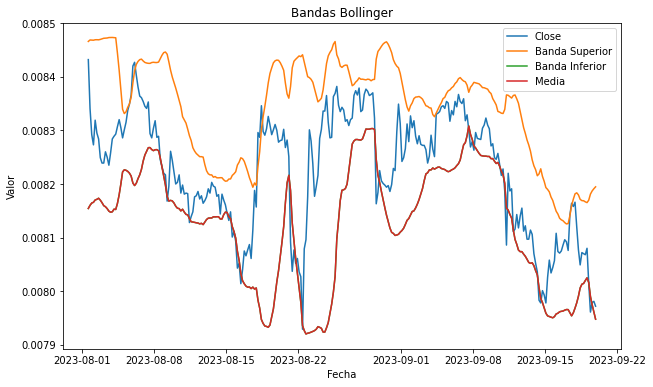

In [44]:
# Graficar las Bandas Bollinger
start_date = '2023-08-01 10:00:00'

df_plot = df[df.index>start_date].copy()
plt.figure(figsize=(10, 6))
plt.plot(df_plot.index, df_plot[col_use], label='Close')
plt.plot(df_plot.index, df_plot['BBH'], label='Banda Superior')
plt.plot(df_plot.index, df_plot['BBL'], label='Banda Inferior')
plt.plot(df_plot.index, df_plot['BBA'], label='Media')
plt.legend()
plt.title('Bandas Bollinger')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.show()

## Cambio percentual y direccion para el n-esimo periodo


In [52]:

def prueba_hipotesis(df,col_use, alpha, dist='norm', get_data=False):
    '''
    (Function)
        Esta funcion hace 3 pruebas de hipotesis para normalidad
    (Parameters)
        - df: [list, tuple, array, DataFrame, Series] datos sobre los que se desea la prueba de hipotesis
        - col_use: [str] en caso de ser DataFrame usa esa columna para la prueba
        - alpha: [float] Nivel de significancia sobre el que se desea hacer la prueba 0.05 -> 95%
        - dist: [str] tipo de distribucion para hacer la prueba, puede probar: 
                {'norm', 'expon', 'logistic', 'gumbel', 'gumbel_l', 'gumbel_r', 'extreme1'}
        - get_data: [bool] True para retornar el diccionario de datos 
    (Ejemplo de uso)
        > data = np.random.normal(0, 1, 1000)
        > prueba_hipotesis(data,col_use, alpha, dist = 'norm', get_data=False)
    '''
    datos = {}
    
    if isinstance(df,pd.DataFrame):
        data = df[col_use].dropna()
    elif isinstance(df, (np.ndarray, list, tuple, pd.Series)):
        data = df

    # Realiza la prueba de Anderson-Darling
    result = stats.anderson(data,dist=dist) 
    # Comprueba si la muestra sigue una distribución normal basada en el estadístico de prueba
    if result.statistic < result.critical_values[2]:
        res = "Sigue distribucion"
    else:
        res = "No sigue distribucion"

    # apendamos los valores necesarios
    datos.update({"Anderson-Darling":{'Est_prueba':result.statistic,
                                    "P-value":result.critical_values[2],
                                    "Veredicto":res}})


    # Realiza la prueba de Shapiro-Wilk
    statistic, p_value = stats.shapiro(data)

    # Comprueba si la muestra sigue una distribución normal basada en el valor p
    if p_value > alpha:
        res = "Sigue distribucion"
    else:
        res = "No sigue distribucion"
        
    # apendamos los valores necesarios
    datos.update({"Shapiro-Wilk":{'Est_prueba':statistic,
                                    "P-value":p_value,
                                    "Veredicto":res}})


    # Realiza la prueba de Kolmogorov-Smirnov
    kstest_result = stats.kstest(data, dist)

    if kstest_result.pvalue > alpha:
        res = "Sigue distribucion"
    else:
        res = "No sigue distribucion"
        
    # apendamos los valores necesarios
    datos.update({"Kolmogorov-Smirnov":{'Est_prueba':kstest_result.statistic,
                                    "P-value":kstest_result.pvalue,
                                    "Veredicto":res}})


    table = []
    for test, values in datos.items():
        row = [test, values['Est_prueba'], values['P-value'], values['Veredicto']]
        table.append(row)

    headers = ['Prueba', 'Estadístico de Prueba', 'Valor P', 'Veredicto']
    table_str = tabulate(table, headers, tablefmt='grid')

    print(table_str)
    if get_data:
        return datos

def get_cols_pc_and_dir(n_period,col_use,separeted=True):
    cols_pc = []
    cols_dir = []
    for i in range(1,n_period+1):
        cols_pc.append(col_use+'_pc_'+str(i))
        cols_dir.append(col_use+'_dir_'+str(i))
    if separeted:
        return cols_dir, cols_pc
    else:
        return cols_dir + cols_pc


In [59]:
from fn_prep import change_percentual
n_period = 1
col_use = "Close"

cols_dir, cols_pc = get_cols_pc_and_dir(n_period,col_use)

df = change_percentual(df,col_use,n_periods=n_period,
                      get_direction=True,all_periods=True)

df[[col_use]+cols_dir+cols_pc]

,Close,Close_dir_1,Close_pc_1
Close_Time,,,
2020-01-01 06:00:00,0.001906,UP,0.251204
2020-01-01 10:00:00,0.001911,DOWN,-0.674394
2020-01-01 14:00:00,0.001898,UP,0.288941
2020-01-01 18:00:00,0.001904,DOWN,-0.326780
2020-01-01 22:00:00,0.001897,DOWN,-0.375622
...,...,...,...
2023-09-19 06:00:00,0.008015,DOWN,-0.678307
2023-09-19 10:00:00,0.007961,UP,0.225592
2023-09-19 14:00:00,0.007979,UP,0.025060


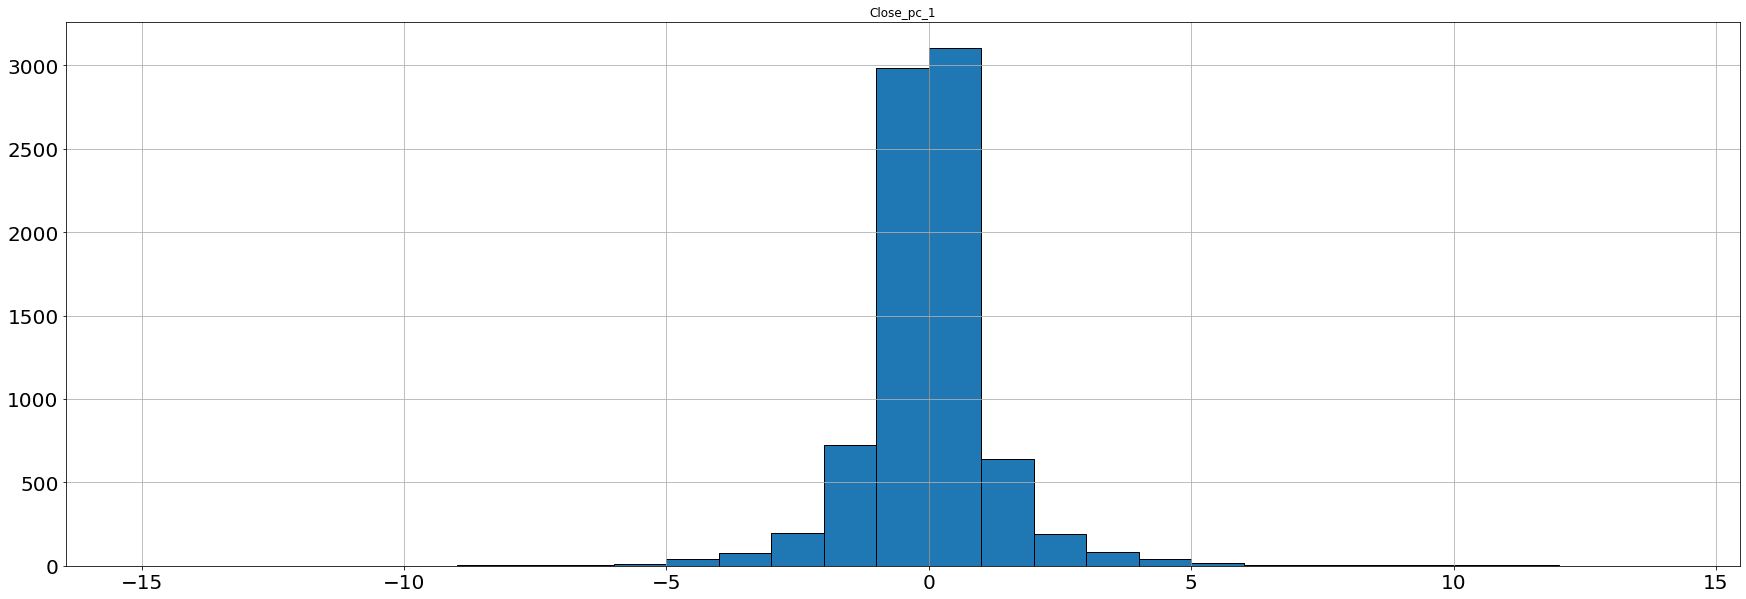

In [61]:

df[cols_pc].hist(bins=range(-15,15), edgecolor='black',
                  figsize=(30,10),
                  xlabelsize=20,ylabelsize=20);

In [102]:
col_using = "Close_pc_1"
alpha = 0.05
dist="norm" #dist : {'norm', 'expon', 'logistic', 'gumbel', 'gumbel_l', 'gumbel_r', 'extreme1'}

data = np.random.normal(0, 1, 1000)
prueba_hipotesis(df,col_using, alpha, dist = 'norm', get_data=False)



+--------------------+-------------------------+-------------+-----------------------+
| Prueba             |   Estadístico de Prueba |     Valor P | Veredicto             |
+====================+=========================+=============+=======================+
| Anderson-Darling   |             291.705     | 0.787       | No sigue distribucion |
+--------------------+-------------------------+-------------+-----------------------+
| Shapiro-Wilk       |               0.826346  | 0           | No sigue distribucion |
+--------------------+-------------------------+-------------+-----------------------+
| Kolmogorov-Smirnov |               0.0709051 | 4.71516e-36 | No sigue distribucion |
+--------------------+-------------------------+-------------+-----------------------+


## Particionado de datos.

In [113]:
# Dividir df en X y Y

## Columna usada para el cambio percentual y direccion
col_use = "Close"
## En caso de querer y multiclase hacer True
incluir_todos_periodos = False 
## Si no incluye todos los periodos con cual se queda
ind = 1 
## Para incluir el ultimo precio en los datos
incluir_ultimo = True
## Solo funciona 
predecir = "_pc"  # _dir, _pc

if incluir_todos_periodos:
    if predecir == "_pc":
        cols_x = ['Open', 'High', 'Low', 'Close', 'Volume',
                'Quote_asset_vol', 'Number_trades', 'Taker_buy_base',
                'Taker_buy_quote']+[valor for valor in df.columns if "_dir" in valor]  
        col_y = [valor for valor in df.columns if "_pc" in valor]
    elif predecir == "_dir":
        cols_x = ['Open', 'High', 'Low', 'Close', 'Volume',
                'Quote_asset_vol', 'Number_trades', 'Taker_buy_base',
                'Taker_buy_quote']+[valor for valor in df.columns if "_pc" in valor]  
        col_y = [valor for valor in df.columns if "_dir" in valor]
else:
    if predecir == "_pc":
        cols_x = ['Open', 'High', 'Low', 'Close', 'Volume',
            'Quote_asset_vol', 'Number_trades', 'Taker_buy_base',
            'Taker_buy_quote',col_use+'_dir_'+str(ind)]
        col_y = col_use+"_pc_"+str(ind)
    
    elif predecir == "_dir":
        cols_x = ['Open', 'High', 'Low', 'Close', 'Volume',
                'Quote_asset_vol', 'Number_trades', 'Taker_buy_base',
                'Taker_buy_quote','Close_pc_'+str(ind)]
        col_y = "Close_dir_"+str(ind)
        

df.rename(columns={'Volumne':'Volume'},inplace=True)

if not incluir_ultimo:
    X = df[cols_x].iloc[:-1].copy()
    y = df[col_y].iloc[:-1].copy()
    X_last = df[cols_x].iloc[-1:, :].copy()
    y_last = df[col_y].iloc[-1:].copy()
else:
    y = df[col_y].copy()
    X = df[cols_x].copy()
    

#
#X_last = df[cols_x].iloc[-1:, :].copy()



In [143]:
# Revisamos que todas las columnas sean numericas
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8146 entries, 2020-01-01 06:00:00 to 2023-09-19 22:00:00
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open             8146 non-null   float64
 1   High             8146 non-null   float64
 2   Low              8146 non-null   float64
 3   Close            8146 non-null   float64
 4   Volume           8146 non-null   float64
 5   Quote_asset_vol  8146 non-null   float64
 6   Number_trades    8146 non-null   int64  
 7   Taker_buy_base   8146 non-null   float64
 8   Taker_buy_quote  8146 non-null   float64
 9   Close_dir_1      8146 non-null   int64  
dtypes: float64(8), int64(2)
memory usage: 700.0 KB


In [142]:
X.Close_dir_1 = X.Close_dir_1.map({'UP':1,'DOWN':0})

In [114]:
X.columns, y.name

(Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote_asset_vol',
        'Number_trades', 'Taker_buy_base', 'Taker_buy_quote', 'Close_dir_1'],
       dtype='object'),
 'Close_pc_1')

In [146]:
n = X.shape[0]
train_size = .8

x_train, x_test = X.iloc[:int(n*train_size)].copy(), X.iloc[int(n*train_size):].copy()
yy_train, yy_test = y.iloc[:int(n*train_size)].copy(), y.iloc[int(n*train_size):].copy()
print(x_train.shape[0]+ x_test.shape[0]==df.shape[0])
x_train.shape, x_test.shape

True


((6516, 10), (1630, 10))

## Ingenieria de caracteristicas

### Volatilidad
Medimos la volatilidad con el coeficiente de variacion que hay en los rendimientos

In [ ]:
import tqdm
from fn_prep import get_volatilidad

In [ ]:
df = df_respaldo.copy()
df.columns

In [ ]:
columns_use = ["Close","Open","High","Low"]
list_statistics = get_volatilidad(df,columns_use)
list_statistics

In [ ]:
# Obtener la clave con el valor máximo
clave_maxima = max(list_statistics, key=lambda k: list_statistics[k])
list_statistics,clave_maxima

In [ ]:
import time 
simbolos = ['BNBBTC', 'BNBETH', 'BNBUSDT', 'BNBTUSD', 'BNBUSDC', 'BNBBUSD',
       'BNBRUB', 'BNBTRY', 'BNBEUR', 'BNBGBP', 'BNBBIDR', 'BNBDAI',
       'BNBBRL', 'BNBUAH', 'BNBFDUSD']
intervalos = ["1d","12h","8h","6h","4h","2h","1h"]
cols_cv = ["Close","Open","High","Low"]

dict_final = {}
for symbol in tqdm.tqdm(simbolos):
    for interval in intervalos:
        # NOmbre de la tabla
        table_name = symbol+'_'+interval
        
        # cargamos la tabla
        try:
            df_aux = pd.read_sql_query(f'''
                        SELECT *
                        FROM {table_name}
                        ORDER BY Open_Time 
                        ''', con)
            df_aux.Name = table_name
        except:
            print('Fallo al leer ',table_name)
            
        # Generamos la volatilidad
        dict_final[table_name] = get_volatilidad(df_aux,cols_cv)
        time.sleep(1)

In [ ]:
df_vol = pd.DataFrame(dict_final).T
df_vol['Volatilidad_max']  = df_vol.apply(lambda x: max(x[df_vol.columns].values), axis=1)
df_vol['Col_max'] = df_vol.apply(lambda x: max(x[df_vol.columns].values), axis=1).index


In [ ]:
df_vol.loc[[valor for valor in df_vol.index if "_1d" in valor]].sort_values("Volatilidad_max",ascending=False)

In [ ]:
df_vol.loc[[valor for valor in df_vol.index if "_4h" in valor]].sort_values("Volatilidad_max",ascending=False)

In [ ]:
df_vol.loc[[valor for valor in df_vol.index if "_4h" in valor]].sort_values("Volatilidad_max",ascending=False).plot(kind="bar",y=["Volatilidad_max"],)

In [ ]:
n_days_ago = 6
last_day = df_aux['Open_Time'].iloc[-1]
ago = last_day - timedelta(days=n_days_ago)
ago

In [ ]:
df_cp_aux = change_percentual(df_aux[df_aux["Open_Time"]>= ago],"Close",2,get_direction=False)
df_cp_aux[["Close_pc_1", "Close_pc_2"]].mean()

In [ ]:

df_aux.Open_Time.dt.day_name()

## Modelos de clasificacion

In [ ]:
from datetime import timedelta
from sklearn.model_selection import TimeSeriesSplit
ts = TimeSeriesSplit(test_size=200)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score

df_parameters = pd.DataFrame()

def show_matriz_confusion(matriz_confusion):
    # Crear una visualización de la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Clase 0", "Clase 1"],
                yticklabels=["Clase 0", "Clase 1"])
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.show()





def grid_search_random_forest(X, y,rf_model, param_grid, cv=5, verbose=1, scoring='accuracy'):
    # Crear el modelo RandomForest
    #rf_model = RandomForestClassifier(random_state=42)
    
    # Realizar Grid Search
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                               scoring=scoring,
                               cv=cv, n_jobs=-1, verbose=verbose)
    
    # Ajustar el modelo
    grid_search.fit(X, y)
    
    return grid_search

def buscar_best(X,y,model,param_grid,cv=5,verbose=1,scoring='accuracy'):
    
    
    # Realizar la búsqueda en cuadrícula
    grid_search = grid_search_random_forest(X, y, model, param_grid,cv,verbose,scoring)
    
    # Imprimir los mejores parámetros y el mejor puntaje
    print("Mejores parámetros:", grid_search.best_params_)
    print("Mejor puntaje:", grid_search.best_score_)
    return grid_search

In [199]:
# Modelo RandomForestClassifier
# Muy pesado, no util para [UP, DOWN]
n_estimators = [50,100, 200, 300], # Cantidad de arboles
max_depth = [ 10, 20,30,50],
min_samples_split = [2, 5, 10], # Cantidad de muestras para dividir un nodo
min_samples_leaf = [1, 2, 4,10],   # Cantidad de muestras para dividir una hoja
max_features =  ['auto', 'sqrt']

error_mse_list = []
accuracy_list = [0]
model_chido = None

besth_depth = []
best_estimator = []
best_split = []
best_leaf = []
best_feature = []
best_acuracy = []
best_score = []


for estimator in [50,100, 200, 300]:
    for depth1 in [ 10, 20,30,50]:
        for split in [2, 5, 10]:
            for leaf in [1, 2, 4,10]:
                for feature in ['log2', 'sqrt']:
                    model = RandomForestClassifier(n_estimators=estimator,
                                                   max_depth=depth1,
                                                   min_samples_split=split,
                                                   min_samples_leaf=leaf,
                                                   max_features=feature)
                    for index_train, index_test in ts.split(X_test.iloc[:-1,:]):
                        X_train, y_train = X.iloc[index_train], y.iloc[index_train]
                        X_test, y_test = X.iloc[index_test], y.iloc[index_test]
                        
                        model.fit(X_train, y_train)
                        
                        y_pred = model.predict(X_test)
                        
                        #error_mse = mean_squared_error(y_test, y_pred)
                        #error_mse_list.append(error_mse)
                        #print(f'El MSE es: {error_mse}')
                        
                        acuracy = accuracy_score(y_test, y_pred)
                        
                        #print(f'El acuracy es: {acuracy}')
                        #print(acuracy > max(accuracy_list))
                        
                        if acuracy > max(accuracy_list):
                            
                            score = model.score(X_train, y_train)
                            print(f'El acuracy es: {acuracy}')
                            print(f'Score del modelo: {score}')
                            model_chido = model
                            besth_depth.append(depth1)
                            best_estimator.append(estimator)
                            best_split.append(split)
                            best_leaf.append(leaf)
                            best_feature.append(feature)
                            best_acuracy.append(acuracy)
                            best_score.append(score)
                            
                            # Calcular la matriz de confusión
                            clases = model.classes_
                            matriz_confusion = confusion_matrix(y, y_pred,labels=clases)
                            show_matriz_confusion(matriz_confusion)
                            
                        accuracy_list.append(acuracy)
                        
                        best_estimator = np.array(best_estimator)*0
accuracy_list.remove(0)
df_aux = pd.DataFrame({'Depth':besth_depth,
                        'Estimator':best_estimator,
                        'Split': best_split,
                        'Leaf':best_leaf,
                        'Feature':best_feature,
                        'Accuracy':best_acuracy})
df_parameters = pd.concat([df_parameters,df_aux])

print('RESULTADOS'.center(100,'-'))
print('Se obtuvo en un pormedio de ',np.mean(accuracy_list),' en el accuracy')
print('Cuya desvicion estandar fue de: ',np.std(accuracy_list))
# (mean, n) = (0.5021733472149922, 1921)

NameError: name 'RandomForestClassifier' is not defined

In [ ]:
# Modelo DecisionTreeClassifier


def train_DecisionTreeClassifier(X,y,ts,df_parameters=pd.DataFrame(),show_hist=True):
    import numpy as np
    accuracy_list = [0]
    model_chido = None
    besth_depth = []
    best_split = []
    best_leaf = []
    best_feature = []
    best_acuracy = []
    best_score = []
    dict_best_parameters = {}
    df_split = X.copy()



    for depth1 in [ 10, 20,30,50,80]:
        for split in [2, 5, 10]:
            for leaf in [1, 3, 7,10]:
                for feature in ['log2', 'sqrt']:
                    # Invocamos al modelo
                    model = DecisionTreeClassifier(
                                                    max_depth=depth1,
                                                    min_samples_split=split,
                                                    min_samples_leaf=leaf,
                                                    max_features=feature)
                    
                    # Entrenamos con particion de TimeSeriesSplit
                    for index_train, index_test in ts.split(df_split):
                        X_train, y_train = X.iloc[index_train], y.iloc[index_train]
                        X_test, y_test = X.iloc[index_test], y.iloc[index_test]
                        
                        model.fit(X_train, y_train)
                        
                        y_pred = model.predict(X_test)
                        
                        #error_mse = mean_squared_error(y_test, y_pred)
                        #error_mse_list.append(error_mse)
                        #print(f'El MSE es: {error_mse}')
                        
                        acuracy = accuracy_score(y_test, y_pred)
                        
                        #print(f'El acuracy es: {acuracy}')
                        #print(acuracy > max(accuracy_list))
                        
                        if acuracy > max(accuracy_list):
                            score = model.score(X_train, y_train)
                            print(f'El acuracy es: {acuracy}')
                            print(f'Score del modelo: {score}')
                            
                            # Cremos diccionario
                            dict_best_parameters["max_depth"] = depth1
                            dict_best_parameters["min_samples_split"] = split
                            dict_best_parameters["min_samples_leaf"] = split
                            dict_best_parameters["max_features"] = split
                            
                            model_chido = model
                            besth_depth.append(depth1)
                            best_split.append(split)
                            best_leaf.append(leaf)
                            best_feature.append(feature)
                            best_acuracy.append(acuracy)
                            best_score.append(score)
                            
                            # Calcular la matriz de confusión
                            clases = model.classes_
                            matriz_confusion = confusion_matrix(y_test, y_pred,labels=clases)
                            show_matriz_confusion(matriz_confusion)
                            
                            
                        accuracy_list.append(acuracy)
                        if acuracy ==1: break

    accuracy_list.remove(0)
    df_aux = pd.DataFrame({'Depth':besth_depth,
                            'Split': best_split,
                            'Leaf':best_leaf,
                            'Feature':best_feature,
                            'Accuracy':best_acuracy})
    df_parameters = pd.concat([df_parameters,df_aux])

    print('RESULTADOS'.center(100,'-'))
    print('Se obtuvo en un promedio de ',np.mean(accuracy_list),' en el accuracy')
    print('Cuya desvicion estandar fue de: ',np.std(accuracy_list))

    if show_hist:
        import numpy as np 
        import matplotlib.pyplot as plt

        print(f'Se hicieron {len(accuracy_list)} pruebas \nel accuracy medio fue: {np.mean(accuracy_list)}')


        plt.hist(accuracy_list,bins=10,edgecolor='black')
        plt.title("Histograma de accuracy")
        plt.show()
    return model_chido, df_parameters, dict_best_parameters


In [ ]:
df_parameters=pd.DataFrame()

In [ ]:
show_hist = True
model_chido, df_parameters, dict_best_parameters = train_DecisionTreeClassifier(X,y,ts,df_parameters,show_hist)


In [ ]:
df_parameters

In [ ]:
dict_best_parameters

In [ ]:
model_test = DecisionTreeClassifier(**dict_best_parameters)
model_test.fit(x_train,yy_train)

In [ ]:
accuracy_score(yy_test,model_chido.predict(x_test))

In [ ]:
# Usando optimizador GridSearchCV

# Definir el rango de valores para cada parámetro
param_grid = {
   # 'n_estimators': [50,100, 200, 300], # Cantidad de arboles
    'max_depth': [ 10, 20,30,50],
    'min_samples_split': [2, 5, 10], # Cantidad de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4,10],   # Cantidad de muestras para dividir una hoja
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy', 'log_loss']
}
scoring = 'accuracy'

model = DecisionTreeClassifier(random_state=42)

gs = buscar_best(X_train,y_train,model,param_grid,cv=ts,verbose=1,scoring=scoring)

# Evaluar el modelo final en los datos de prueba
model_chido = gs.best_estimator_
accuracy = model_chido.score(X_test, y_test)
print("Accuracy en los datos de prueba:", accuracy)

In [ ]:
# Ultimo modelo entrenado
y_pred = model_chido.predict(X_test)
acuracy = accuracy_score(y_test, y_pred)
print(f'El acuracy es: {acuracy}')

In [ ]:

model_chido.fit(X,y)

In [ ]:
df.tail()

In [ ]:
# Guardar_modelo
import pickle
name_model = "DecisionTreeClassifier_"+table_name+"_"+datetime.now().strftime("%d-%m-%Y")
with open(f'Models/{name_model}.pkl', 'wb') as f:
    pickle.dump(model_chido, f)

## Modelos de regresion

Aqui te dejo una lista de los scoring que se usan en la regresion
Regression

- ‘explained_variance’: metrics.explained_variance_score

- ‘max_error’: metrics.max_error

- ‘neg_mean_absolute_error’: metrics.mean_absolute_error

- ‘neg_mean_squared_error’: metrics.mean_squared_error

- ‘neg_root_mean_squared_error’: metrics.mean_squared_error

- ‘neg_mean_squared_log_error’: metrics.mean_squared_log_error

- ‘neg_median_absolute_error’: metrics.median_absolute_error

- ‘r2’: metrics.r2_score

- ‘neg_mean_poisson_deviance’: metrics.mean_poisson_deviance

- ‘neg_mean_gamma_deviance’: metrics.mean_gamma_deviance

- ‘neg_mean_absolute_percentage_error’: metrics.mean_absolute_percentage_error

- ‘d2_absolute_error_score’: metrics.d2_absolute_error_score

- ‘d2_pinball_score’: metrics.d2_pinball_score

- ‘d2_tweedie_score’: metrics.d2_tweedie_score


In [201]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import numpy as np

### Bayesian Regression¶
* Las ventajas de la regresión bayesiana son:

Se adapta a los datos disponibles.

Se puede utilizar para incluir parámetros de regularización en el procedimiento de estimación.

* Las desventajas de la regresión bayesiana incluyen:

La inferencia del modelo puede llevar mucho tiempo.

In [200]:
from sklearn.linear_model import BayesianRidge


def entrenar_bayesian_ridge(x_train, y_train, hiperparametros,ts):
    """
    Entrena un modelo BayesianRidge utilizando búsqueda en cuadrícula (grid search) con diferentes hiperparámetros.

    Parameters:
    - x_train: Datos de entrenamiento (numpy array o similar).
    - y_train: Etiquetas de entrenamiento (numpy array o similar).
    - hiperparametros: Diccionario de hiperparámetros a probar.

    Returns:
    - Mejor modelo BayesianRidge encontrado.
    """

    # Crear el modelo BayesianRidge
    modelo = BayesianRidge()

    # Crear el objeto GridSearchCV para búsqueda en cuadrícula
    grid_search = GridSearchCV(modelo, hiperparametros, cv=ts, scoring=('neg_mean_squared_error'))

    # Entrenar el modelo con diferentes hiperparámetros
    grid_search.fit(x_train, y_train)

    # Devolver el mejor modelo encontrado
    mejor_modelo = grid_search.best_estimator_

    return mejor_modelo

# Ejemplo de uso:
def train_BayesianRidge(x_train,y_train,ts):
    # Datos de entrenamiento de ejemplo

    # Hiperparámetros a probar (ejemplo)
    hiperparametros = {
        'alpha_1':  [1e-6, 1e-5, 1e-4,1e-3,1e-2,1e-1,1e-0],
        'alpha_2':  [1e-6, 1e-5, 1e-4,1e-3,1e-2,1e-1,1e-0],
        'lambda_1': [1e-6, 1e-5, 1e-4,1e-3,1e-2,1e-1,1e-0],
        'lambda_2': [1e-6, 1e-5, 1e-4,1e-3,1e-2,1e-1,1e-0],
        'tol': [0.001,0.01,0.1,1]
    }

    # Entrenar el modelo BayesianRidge con búsqueda en cuadrícula
    mejor_modelo = entrenar_bayesian_ridge(x_train, y_train, hiperparametros,ts)

    # Imprimir los hiperparámetros del mejor modelo encontrado
    print("Mejores hiperparámetros:")
    print(mejor_modelo.get_params())
    print('Score', mejor_modelo.scores_)
    return mejor_modelo, mejor_modelo.get_params()


In [164]:
model.score(x_train,yy_train)

0.38406808714597873

In [163]:
ts = TimeSeriesSplit(test_size=200)
model,params = train_BayesianRidge(x_train,yy_train,ts)

Mejores hiperparámetros:
{'alpha_1': 1.0, 'alpha_2': 1e-06, 'alpha_init': None, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1e-06, 'lambda_2': 1.0, 'lambda_init': None, 'max_iter': None, 'n_iter': 'deprecated', 'tol': 0.001, 'verbose': False}
Score []


In [165]:
modelo = BayesianRidge(**params)
modelo.fit(x_train,yy_train)

BayesianRidge(alpha_1=1.0, lambda_2=1.0)

In [166]:
modelo.score(x_train,yy_train)

0.38406808714597873

Conclusion 20/09/23 es muy tardado y poco eficiente
el maxim score obtenido es de 0.38406808714597873 tardando 12 min cuyos parametros fueron:

{'alpha_1': 1.0, 'alpha_2': 1e-06, 'alpha_init': None, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1e-06, 'lambda_2': 1.0, 'lambda_init': None, 'max_iter': None, 'n_iter': 'deprecated', 'tol': 0.001, 'verbose': False}

### Arbol de regresion

In [210]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

def entrenar_decision_tree(x_train, y_train, hiperparametros,ts):
    """
    Entrena un modelo DecisionTreeRegressor utilizando búsqueda en cuadrícula (grid search) con diferentes hiperparámetros.

    Parameters:
    - x_train: Datos de entrenamiento (numpy array o similar).
    - y_train: Etiquetas de entrenamiento (numpy array o similar).
    - hiperparametros: Diccionario de hiperparámetros a probar.

    Returns:
    - Mejor modelo DecisionTreeRegressor encontrado.
    """

    # Crear el modelo DecisionTreeRegressor
    modelo = DecisionTreeRegressor()

    # Crear el objeto GridSearchCV para búsqueda en cuadrícula
    grid_search = GridSearchCV(modelo, hiperparametros, cv=ts, scoring='neg_mean_squared_error')

    # Entrenar el modelo con diferentes hiperparámetros
    grid_search.fit(x_train, y_train)

    # Devolver el mejor modelo encontrado
    mejor_modelo = grid_search.best_estimator_

    # Obtener los resultados de la búsqueda en cuadrícula
    resultados = grid_search.cv_results_
   

    # Graficar los puntajes en función de los hiperparámetros
    #graficar_resultados(resultados, hiperparametros)

    return mejor_modelo


# Ejemplo de uso:
def train_DecisionTreeRegresor(x_train,y_train,ts):
    # Datos de entrenamiento de ejemplo
    #x_train = np.array([[1, 2], [2, 3], [3, 4], [4, 5]])
    #y_train = np.array([1, 2, 3, 4])

    # Hiperparámetros a probar (ejemplo)
    hiperparametros = {
        'max_depth': [None,3, 5, 10, 15,30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        "criterion":["squared_error", "friedman_mse", "absolute_error", "poisson"],
        "splitter": ["best", "random"],
        "max_features":["auto", "sqrt", "log2"],
        "max_leaf_nodes":[2,5,10],
        "min_weight_fraction_leaf":[0,0.01,0.1,0.3]
    }

    # Entrenar el modelo DecisionTreeRegressor con búsqueda en cuadrícula y visualizar los gráficos
    mejor_modelo = entrenar_decision_tree(x_train, y_train, hiperparametros,ts)

    # Imprimir los hiperparámetros del mejor modelo encontrado
    print("Mejores hiperparámetros:")
    print(mejor_modelo.get_params())
    return mejor_modelo, mejor_modelo.get_params()


In [211]:
ts = TimeSeriesSplit(test_size=100)
model, params = train_DecisionTreeRegresor(x_train,yy_train,ts)

Mejores hiperparámetros:
{'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.01, 'random_state': None, 'splitter': 'best'}


In [212]:
model.score(x_train,yy_train)

0.421552050872366

Conclusion

score: 042 parametros: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'random'}

score: 0.39 time: 9m parametros: {'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

score: 0.46, time:13.2, parametros: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

score: 0.50, time 7m, parametros: {'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

score: 0.44, time: 11m, parametros: {'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

score: 0.42, time: 81m, parametros: {'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.01, 'random_state': None, 'splitter': 'best'}

## Backtesting

### Sobre clasificacion

In [ ]:
# Leer el modelo
import pickle
from sklearn.metrics import accuracy_score
with open('Models/DecisionTreeClassifier.pkl', 'rb') as f:
    model_chido = pickle.load(f)

print('Acuracy del modelo sobre set de testeo: ',accuracy_score(yy_test, model_dt.predict(x_test)))

In [ ]:
df.Name

In [ ]:
print(accuracy)

In [ ]:
# Bactesting
from backtesting import Strategy, Backtest

class ClassificationUP(Strategy):
    def init(self):
        # Instanciamos el modelo
        self.model = model_dt  #model_chido, best_model
        # Indicadora sobre si ya hemos comprado
        self.already_bought = False

    def next(self):
        # Variable global de Strategy data.df
        #print(self.data.df.columns)
        explanatory_today = self.data.df.iloc[-1:, :]
        forecast_tomorrow = self.model.predict(explanatory_today)[0]

        # conditions to sell or buy

        ## Buy
        if forecast_tomorrow == 'UP' and self.already_bought == False:
            self.buy()
            self.already_bought = True

        ## Sell
        elif forecast_tomorrow == 'DOWN' and self.already_bought == True:
            self.sell()
            self.already_bought = False

        ## Nothing
        else: pass
        
        
bt = Backtest(data=X.iloc[:-1], strategy=ClassificationUP,
              cash=20000, commission=.002, exclusive_orders=True)
results = bt.run()
results.to_frame(name='Values').loc[:'Avg. Trade Duration']

In [ ]:
X_test.loc[ind]

In [ ]:
0.1/100

Para saber mas acerca sobre la comision en binance [aqui](https://www.binance.com/es/fee/trading)

In [ ]:
model_chido = model_test

In [ ]:
monto = 100
comision = 0.001


# Variables don't move.
open_short = False
open_long  = False
count = 0

for ind in x_test.index:
    
    if count ==0:
        new_monto = monto
    count += 1
    
    # PRediccion
    tomorrow_case = model_chido.predict(df.loc[ind,cols_x].values.reshape(1, -1))
    
    ## Caso 1: Abrir long
    if tomorrow_case=='UP' and open_long==False and open_short==False:
        df.loc[ind, 'Operacion'] = 'Open_Long'
        price_operation = df.loc[ind,'Close']
        open_long = True
        new_monto = new_monto*(1-comision)
    
    ## Caso 2: Abrir short
    elif tomorrow_case=='DOWN' and open_long==False and open_short==False:
        df.loc[ind, 'Operacion'] = 'Open_Short'
        price_operation = df.loc[ind,'Close']
        open_short = True
        new_monto = new_monto*(1-comision)
    
    ## Caso 3: Cerrar Long
    elif tomorrow_case=='DOWN' and open_long==True and open_short==False:
        df.loc[ind, 'Operacion'] = 'Close_long'
        ganancia_per = (df.loc[ind,'Close'] - price_operation)/ price_operation
        df.loc[ind,'Ganancia_per'] = ganancia_per *100
        new_monto = new_monto * (1+ganancia_per)
         
        open_long = False
    
    ## Caso 4: Cerrar Short
    elif tomorrow_case=='UP' and open_long==False and open_short==True:
        df.loc[ind, 'Operacion'] = 'Close_Short'
        ganancia_per = ( price_operation - df.loc[ind,'Close'] )/ price_operation
        df.loc[ind,'Ganancia_per'] = ganancia_per * 100
        new_monto = new_monto * (1+ganancia_per)
        
        open_short = False

df.loc[df['Operacion']=='Open_Short', 'Ganancia'] = None
print('Monto actualizado: ', new_monto)


In [ ]:
col_y

In [ ]:
total_trades = df['Operacion'].value_counts()[df['Operacion'].value_counts().index.str.contains('Close')].sum()
print("******************Total de trades = ",total_trades," ***************")
df['Operacion'].value_counts()

In [ ]:
df['Prediccion'] = model_chido.predict(df[cols_x])
df[['Close','Close_dir_2',"Prediccion",'Operacion','Ganancia_per']].iloc[-x_test.shape[0]:].to_csv('Data/Prueba_back.csv')

In [ ]:
cols_x

### Conclusiones 

***01-09-2023*** </br>
El modelo arbol de decision resulta ser mu bueno para estimar el movimiento del periodo siguiente. </br>
Se usaron las columnas: 

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Quote_asset_vol',
 'Number_trades',
 'Taker_buy_base',
 'Taker_buy_quote',
 'Close_pc']

 precision del 100%


# otro

In [10]:
# Encripta el archivo credenciales.txt con la clave generada
encriptar_archivo('Data/credenciales.txt', clave)


In [8]:
# Escribe la información desencriptada en otro archivo
escribir_desencriptado('Data/vacio.txt', 'Data/IP.txt', clave_file1)